In [1]:
import numpy as np
import pandas as pd
import glob, os, sys, time
sys.path.append('/Users/shiyunqiu/dmm/')
from utils.misc import getConfigFile, readPickle, displayTime, loadHDF5,getLowestError
from   model_th.dmm import DMM
import model_th.learning as DMM_learn
import model_th.evaluate as DMM_evaluate
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20

/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('/Users/shiyunqiu/AM231_Project/data/bitcoin_price.csv')
df = df[::-1]
df = df.Close.values.reshape(-1,1)
print(df.shape)

(1760, 1)


In [3]:
def generate_sample(T, nsample, start_indx, end_indx):
    sample = []
    idx = np.random.randint(start_indx, end_indx, nsample, 'int')
    for i, val in enumerate(idx):
        piece = df[val:val+10, :]
        sample.append(piece)
    return np.array(sample)

In [4]:
# create dataset to pass into DKF

# size of each set
train_size = int(len(df) * 0.9)
valid_size = int(len(df) * 0.1)-10
test_size = 10
# Train: T=10, 1000 samples
train = generate_sample(10, 1000, 0, train_size-10)

# Valid: T=10, 100 samples
valid = generate_sample(10, 100, train_size, train_size+valid_size-10)

# Test: T=10, 1 sample
test = np.array([df[-10:, :]])

train_dict = {}
train_dict['tensor'] = train
train_dict['mask'] = np.ones((1000, 10))

valid_dict = {}
valid_dict['tensor'] = valid
valid_dict['mask'] = np.ones((100, 10))

test_dict = {}
test_dict['tensor'] = test
test_dict['mask'] = np.ones((1, 10))

dataset = {}
dataset['dim_observations'] = 1
dataset['data_type'] = 'real'
dataset['train'] = train_dict
dataset['valid'] = valid_dict
dataset['test'] = test_dict

print 'Dimensionality of the observations: ', dataset['dim_observations']
print 'Data type of features:', dataset['data_type']
for dtype in ['train','valid','test']:
    print 'dtype: ',dtype, ' type(dataset[dtype]): ',type(dataset[dtype])
    print [(k,type(dataset[dtype][k]), dataset[dtype][k].shape) for k in dataset[dtype]]
    print '--------\n'

Dimensionality of the observations:  1
Data type of features: real
dtype:  train  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1000, 10)), ('tensor', <type 'numpy.ndarray'>, (1000, 10, 1))]
--------

dtype:  valid  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (100, 10)), ('tensor', <type 'numpy.ndarray'>, (100, 10, 1))]
--------

dtype:  test  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1, 10)), ('tensor', <type 'numpy.ndarray'>, (1, 10, 1))]
--------



In [5]:
# load parameter
params = readPickle('default.pkl')[0]
for k in params:
    print k, '\t',params[k]

Read  1  objects
dataset 	mm
epochs 	2000
seed 	1
init_weight 	0.1
dim_stochastic 	100
expt_name 	uid
reg_value 	0.05
reloadFile 	./NOSUCHFILE
reg_spec 	_
dim_hidden 	200
lr 	0.0008
reg_type 	l2
init_scheme 	uniform
optimizer 	adam
use_generative_prior 	approx
maxout_stride 	4
batch_size 	20
savedir 	./chkpt
forget_bias 	-5.0
inference_model 	R
emission_layers 	2
savefreq 	10
rnn_cell 	lstm
rnn_size 	600
paramFile 	./NOSUCHFILE
nonlinearity 	relu
rnn_dropout 	0.1
transition_layers 	2
anneal_rate 	2.0
debug 	False
validate_only 	False
transition_type 	mlp
unique_id 	DMM_lr-0_0008-dh-200-ds-100-nl-relu-bs-20-ep-2000-rs-600-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid
leaky_param 	0.0


In [6]:
# modify parameters
params['data_type'] = dataset['data_type']
params['dim_observations'] = dataset['dim_observations']

#The dataset is small, lets change some of the default parameters and the unique ID
params['dim_stochastic'] = 2
params['dim_hidden']     = 20
params['rnn_size']       = 40
params['epochs']         = 500
params['batch_size']     = 200
params['unique_id'] = params['unique_id'].replace('ds-100','ds-2').replace('dh-200','dh-20').replace('rs-600','rs-40')
params['unique_id'] = params['unique_id'].replace('ep-2000','ep-500').replace('bs-20','bs-200')

#Create a temporary directory to save checkpoints
params['savedir']   = params['savedir']+'-ipython/'
os.system('mkdir -p '+params['savedir'])

#Specify the file where `params` corresponding for this choice of model and data will be saved
pfile= params['savedir']+'/'+params['unique_id']+'-config.pkl'

print 'Checkpoint prefix: ', pfile

Checkpoint prefix:  ./chkpt-ipython//DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl


In [7]:
# build dmm
dmm  = DMM(params, paramFile = pfile)

	<<Sampling biases for LSTM from exponential distribution>>
	<<Nparameters: 14410>>
	<<WARNING: lr will not differentiated with respect to>>
	<<WARNING: anneal will not differentiated with respect to>>
	<<WARNING: update_ctr will not differentiated with respect to>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.1>>
	<<In _LSTM_RNN_layer with dropout 0.1000>>
	<<Modifying : [q_W_input_0,q_b_input_0,W_lstm_r,b_lstm_r,U_lstm_r,q_W_st,q_b_st,q_W_mu,q_b_mu,q_W_cov,q_b_cov,p_trans_W_0,p_trans_b_0,p_trans_W_1,p_trans_b_1,p_trans_W_mu,p_trans_b_mu,p_trans_W_cov,p_trans_b_cov,p_emis_W_0,p_emis_b_0,p_emis_W_1,p_emis_b_1,p_emis_W_out,p_emis_b_out]>>
<< Reg:(l2) Reg. Val:(0.05) Reg. Spec.:(_)>>
<<<<<< Adding l2 regularization for q_W_input_0 >>>>>>
<<<<<< Adding l2 regularization for q_b_input_0 >>>>>>
<<<<<< Adding l2 regularization for W_lstm_r >>>>>>
<<<<<< Adding l2 regularization for b_lstm_r >>>>>>
<<<<<< Adding l2 regularization for U_lstm_r >>>>>>
<<<<<< Adding l2 re

In [8]:
# parameter estimation
#savef specifies the prefix for the checkpoints - we'll use the same save directory as before 
savef    = os.path.join(params['savedir'],params['unique_id'])
savedata = DMM_learn.learn(dmm, dataset['train'], epoch_start =0 ,
                                epoch_end = params['epochs'],
                                batch_size = 200,
                                savefreq   = params['savefreq'],
                                savefile   = savef,
                                dataset_eval=dataset['valid'],
                                shuffle    = True )

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [1000   10    1],[1000   10]>>
	<<Bnum: 0, Batch Bound: 447338.0830, |w|: 22.2577, |dw|: 1.0000, |w_opt|: 0.0000>>
	<<-veCLL:894676165.1172, KL:85.3527, anneal:0.0100>>
	<<(Ep 0) Bound: 412609.3916 [Took 0.2425 seconds] >>
	<<Saving at epoch 0>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP0-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP0-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100  10   1],[100  10]>>
	<<(Evaluate) Validation Bound: 50476326.2782 [Took 0.0070 seconds]>>
	<<Original dim: [100  10   1],[100  10]>>
	<<New dim: [1000   10    1],[1000   10]>>
	<<Bnum: 0, Batch Bound: 472202.5437, |w|: 22.2576, |dw|: 1.0000, |w_opt|: 0.4095>>
	<<-veCLL:944404986.1481, KL:101.2015, anneal:1.0000>>
	<<(Ep 1) Bound:

	<<(Ep 31) Bound: 16.2717 [Took 0.2553 seconds] >>
	<<Bnum: 0, Batch Bound: 16.9133, |w|: 22.3714, |dw|: 1.0000, |w_opt|: 0.9550>>
	<<-veCLL:26549.7030, KL:7276.8185, anneal:1.0000>>
	<<(Ep 32) Bound: 15.2094 [Took 0.2167 seconds] >>
	<<Bnum: 0, Batch Bound: 15.2998, |w|: 22.1604, |dw|: 1.0000, |w_opt|: 0.7003>>
	<<-veCLL:23500.4365, KL:7099.2486, anneal:1.0000>>
	<<(Ep 33) Bound: 14.7877 [Took 0.2831 seconds] >>
	<<Bnum: 0, Batch Bound: 13.5460, |w|: 21.9824, |dw|: 1.0000, |w_opt|: 0.5211>>
	<<-veCLL:20891.5002, KL:6200.5289, anneal:1.0000>>
	<<(Ep 34) Bound: 16.2639 [Took 0.2664 seconds] >>
	<<Bnum: 0, Batch Bound: 18.2515, |w|: 21.8798, |dw|: 1.0000, |w_opt|: 0.4485>>
	<<-veCLL:32624.8968, KL:3878.1785, anneal:1.0000>>
	<<(Ep 35) Bound: 17.3030 [Took 0.2367 seconds] >>
	<<Bnum: 0, Batch Bound: 13.3524, |w|: 21.8323, |dw|: 1.0000, |w_opt|: 0.4417>>
	<<-veCLL:22903.0400, KL:3801.6676, anneal:1.0000>>
	<<(Ep 36) Bound: 14.2872 [Took 0.2580 seconds] >>
	<<Bnum: 0, Batch Bound: 12.8852, 

	<<(Ep 67) Bound: 8.8688 [Took 0.2160 seconds] >>
	<<Bnum: 0, Batch Bound: 8.8333, |w|: 21.0453, |dw|: 1.0000, |w_opt|: 0.1785>>
	<<-veCLL:16013.4610, KL:1653.2354, anneal:1.0000>>
	<<(Ep 68) Bound: 8.8224 [Took 0.2225 seconds] >>
	<<Bnum: 0, Batch Bound: 8.9329, |w|: 21.0265, |dw|: 1.0000, |w_opt|: 0.1985>>
	<<-veCLL:16198.4246, KL:1667.4065, anneal:1.0000>>
	<<(Ep 69) Bound: 8.8215 [Took 0.2146 seconds] >>
	<<Bnum: 0, Batch Bound: 8.8917, |w|: 21.0088, |dw|: 1.0000, |w_opt|: 0.1954>>
	<<-veCLL:16263.1733, KL:1520.3004, anneal:1.0000>>
	<<(Ep 70) Bound: 8.8130 [Took 0.2520 seconds] >>
	<<Saving at epoch 70>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP70-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP70-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100  10 

	<<(Ep 101) Bound: 8.5209 [Took 0.2134 seconds] >>
	<<Bnum: 0, Batch Bound: 8.5893, |w|: 20.7159, |dw|: 1.0000, |w_opt|: 0.1362>>
	<<-veCLL:16027.1290, KL:1151.4358, anneal:1.0000>>
	<<(Ep 102) Bound: 8.5213 [Took 0.2085 seconds] >>
	<<Bnum: 0, Batch Bound: 8.3479, |w|: 20.7103, |dw|: 1.0000, |w_opt|: 0.1009>>
	<<-veCLL:15692.8227, KL:1003.0238, anneal:1.0000>>
	<<(Ep 103) Bound: 8.4853 [Took 0.2125 seconds] >>
	<<Bnum: 0, Batch Bound: 8.4065, |w|: 20.7076, |dw|: 1.0000, |w_opt|: 0.1893>>
	<<-veCLL:15748.0388, KL:1064.9404, anneal:1.0000>>
	<<(Ep 104) Bound: 8.4899 [Took 0.2130 seconds] >>
	<<Bnum: 0, Batch Bound: 8.3897, |w|: 20.7052, |dw|: 1.0000, |w_opt|: 0.1180>>
	<<-veCLL:15614.5844, KL:1164.7385, anneal:1.0000>>
	<<(Ep 105) Bound: 8.4787 [Took 0.2141 seconds] >>
	<<Bnum: 0, Batch Bound: 8.5425, |w|: 20.6995, |dw|: 1.0000, |w_opt|: 0.0947>>
	<<-veCLL:15904.7586, KL:1180.2746, anneal:1.0000>>
	<<(Ep 106) Bound: 8.4776 [Took 0.2139 seconds] >>
	<<Bnum: 0, Batch Bound: 8.4708, |w|: 2

	<<(Ep 137) Bound: 8.2424 [Took 0.2119 seconds] >>
	<<Bnum: 0, Batch Bound: 8.2051, |w|: 20.5905, |dw|: 1.0000, |w_opt|: 0.2140>>
	<<-veCLL:15517.5583, KL:892.5949, anneal:1.0000>>
	<<(Ep 138) Bound: 8.2349 [Took 0.2103 seconds] >>
	<<Bnum: 0, Batch Bound: 8.1642, |w|: 20.5930, |dw|: 1.0000, |w_opt|: 0.1946>>
	<<-veCLL:15422.9430, KL:905.5361, anneal:1.0000>>
	<<(Ep 139) Bound: 8.2123 [Took 0.2115 seconds] >>
	<<Bnum: 0, Batch Bound: 8.3160, |w|: 20.5936, |dw|: 1.0000, |w_opt|: 0.2083>>
	<<-veCLL:15669.8797, KL:962.0571, anneal:1.0000>>
	<<(Ep 140) Bound: 8.2114 [Took 0.2182 seconds] >>
	<<Saving at epoch 140>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP140-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP140-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100 

	<<(Ep 171) Bound: 7.9818 [Took 0.2152 seconds] >>
	<<Bnum: 0, Batch Bound: 7.9693, |w|: 20.5742, |dw|: 1.0000, |w_opt|: 0.1481>>
	<<-veCLL:15390.1384, KL:548.5131, anneal:1.0000>>
	<<(Ep 172) Bound: 7.9661 [Took 0.2104 seconds] >>
	<<Bnum: 0, Batch Bound: 7.9285, |w|: 20.5550, |dw|: 1.0000, |w_opt|: 0.1385>>
	<<-veCLL:15316.8283, KL:540.2130, anneal:1.0000>>
	<<(Ep 173) Bound: 7.9747 [Took 0.2116 seconds] >>
	<<Bnum: 0, Batch Bound: 7.9060, |w|: 20.5404, |dw|: 1.0000, |w_opt|: 0.1356>>
	<<-veCLL:15290.8871, KL:521.1808, anneal:1.0000>>
	<<(Ep 174) Bound: 7.9586 [Took 0.2108 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8946, |w|: 20.5294, |dw|: 1.0000, |w_opt|: 0.1666>>
	<<-veCLL:15239.2727, KL:549.8740, anneal:1.0000>>
	<<(Ep 175) Bound: 7.9752 [Took 0.2156 seconds] >>
	<<Bnum: 0, Batch Bound: 8.0038, |w|: 20.5194, |dw|: 1.0000, |w_opt|: 0.1230>>
	<<-veCLL:15468.0798, KL:539.6044, anneal:1.0000>>
	<<(Ep 176) Bound: 7.9565 [Took 0.2165 seconds] >>
	<<Bnum: 0, Batch Bound: 8.0225, |w|: 20.510

	<<(Ep 207) Bound: 7.8787 [Took 0.2155 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8871, |w|: 20.2269, |dw|: 1.0000, |w_opt|: 0.1316>>
	<<-veCLL:15279.7610, KL:494.5038, anneal:1.0000>>
	<<(Ep 208) Bound: 7.8787 [Took 0.2104 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8907, |w|: 20.2186, |dw|: 1.0000, |w_opt|: 0.1812>>
	<<-veCLL:15304.8892, KL:476.6009, anneal:1.0000>>
	<<(Ep 209) Bound: 7.8773 [Took 0.2127 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8162, |w|: 20.2112, |dw|: 1.0000, |w_opt|: 0.1366>>
	<<-veCLL:15140.2902, KL:492.0905, anneal:1.0000>>
	<<(Ep 210) Bound: 7.8768 [Took 0.2127 seconds] >>
	<<Saving at epoch 210>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP210-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP210-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100 

	<<(Ep 241) Bound: 7.8191 [Took 0.2111 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8565, |w|: 20.1395, |dw|: 1.0000, |w_opt|: 0.1384>>
	<<-veCLL:15200.5464, KL:512.4835, anneal:1.0000>>
	<<(Ep 242) Bound: 7.8199 [Took 0.2096 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8444, |w|: 20.1391, |dw|: 1.0000, |w_opt|: 0.1202>>
	<<-veCLL:15215.8552, KL:472.9124, anneal:1.0000>>
	<<(Ep 243) Bound: 7.8199 [Took 0.2177 seconds] >>
	<<Bnum: 0, Batch Bound: 7.7742, |w|: 20.1390, |dw|: 1.0000, |w_opt|: 0.1869>>
	<<-veCLL:15078.2947, KL:470.1937, anneal:1.0000>>
	<<(Ep 244) Bound: 7.8099 [Took 0.2095 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8027, |w|: 20.1397, |dw|: 1.0000, |w_opt|: 0.1939>>
	<<-veCLL:15119.9939, KL:485.5054, anneal:1.0000>>
	<<(Ep 245) Bound: 7.8118 [Took 0.2150 seconds] >>
	<<Bnum: 0, Batch Bound: 7.7285, |w|: 20.1393, |dw|: 1.0000, |w_opt|: 0.1317>>
	<<-veCLL:14983.3725, KL:473.5838, anneal:1.0000>>
	<<(Ep 246) Bound: 7.8153 [Took 0.2103 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8241, |w|: 20.139

	<<(Ep 277) Bound: 7.7250 [Took 0.2127 seconds] >>
	<<Bnum: 0, Batch Bound: 7.8562, |w|: 20.3138, |dw|: 1.0000, |w_opt|: 0.2168>>
	<<-veCLL:15197.3097, KL:515.1335, anneal:1.0000>>
	<<(Ep 278) Bound: 7.7305 [Took 0.2136 seconds] >>
	<<Bnum: 0, Batch Bound: 7.7317, |w|: 20.3235, |dw|: 1.0000, |w_opt|: 0.2553>>
	<<-veCLL:14974.7492, KL:488.6183, anneal:1.0000>>
	<<(Ep 279) Bound: 7.7228 [Took 0.2212 seconds] >>
	<<Bnum: 0, Batch Bound: 7.6953, |w|: 20.3335, |dw|: 1.0000, |w_opt|: 0.1514>>
	<<-veCLL:14873.0124, KL:517.6176, anneal:1.0000>>
	<<(Ep 280) Bound: 7.7092 [Took 0.2120 seconds] >>
	<<Saving at epoch 280>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP280-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP280-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100 

	<<(Ep 311) Bound: 7.5808 [Took 0.2149 seconds] >>
	<<Bnum: 0, Batch Bound: 7.6744, |w|: 20.8088, |dw|: 1.0000, |w_opt|: 0.1589>>
	<<-veCLL:14774.2003, KL:574.6065, anneal:1.0000>>
	<<(Ep 312) Bound: 7.5896 [Took 0.2090 seconds] >>
	<<Bnum: 0, Batch Bound: 7.5822, |w|: 20.8179, |dw|: 1.0000, |w_opt|: 0.1590>>
	<<-veCLL:14560.3279, KL:604.1049, anneal:1.0000>>
	<<(Ep 313) Bound: 7.5672 [Took 0.2152 seconds] >>
	<<Bnum: 0, Batch Bound: 7.4839, |w|: 20.8294, |dw|: 1.0000, |w_opt|: 0.1865>>
	<<-veCLL:14399.5227, KL:568.3558, anneal:1.0000>>
	<<(Ep 314) Bound: 7.5826 [Took 0.2119 seconds] >>
	<<Bnum: 0, Batch Bound: 7.6601, |w|: 20.8391, |dw|: 1.0000, |w_opt|: 0.2606>>
	<<-veCLL:14774.4641, KL:545.7826, anneal:1.0000>>
	<<(Ep 315) Bound: 7.5753 [Took 0.2138 seconds] >>
	<<Bnum: 0, Batch Bound: 7.5436, |w|: 20.8474, |dw|: 1.0000, |w_opt|: 0.1655>>
	<<-veCLL:14500.2824, KL:586.8274, anneal:1.0000>>
	<<(Ep 316) Bound: 7.5593 [Took 0.2163 seconds] >>
	<<Bnum: 0, Batch Bound: 7.6188, |w|: 20.859

	<<(Ep 347) Bound: 7.4789 [Took 0.2130 seconds] >>
	<<Bnum: 0, Batch Bound: 7.5508, |w|: 21.2059, |dw|: 1.0000, |w_opt|: 0.1732>>
	<<-veCLL:14528.3947, KL:573.1101, anneal:1.0000>>
	<<(Ep 348) Bound: 7.4767 [Took 0.2137 seconds] >>
	<<Bnum: 0, Batch Bound: 7.4695, |w|: 21.2186, |dw|: 1.0000, |w_opt|: 0.1748>>
	<<-veCLL:14293.3383, KL:645.7496, anneal:1.0000>>
	<<(Ep 349) Bound: 7.4706 [Took 0.2151 seconds] >>
	<<Bnum: 0, Batch Bound: 7.4043, |w|: 21.2334, |dw|: 1.0000, |w_opt|: 0.1849>>
	<<-veCLL:14218.3829, KL:590.1740, anneal:1.0000>>
	<<(Ep 350) Bound: 7.4641 [Took 0.2125 seconds] >>
	<<Saving at epoch 350>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP350-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP350-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100 

	<<(Ep 381) Bound: 7.3662 [Took 0.2135 seconds] >>
	<<Bnum: 0, Batch Bound: 7.2676, |w|: 21.5435, |dw|: 1.0000, |w_opt|: 0.2073>>
	<<-veCLL:13896.8724, KL:638.3244, anneal:1.0000>>
	<<(Ep 382) Bound: 7.3804 [Took 0.2097 seconds] >>
	<<Bnum: 0, Batch Bound: 7.3275, |w|: 21.5537, |dw|: 1.0000, |w_opt|: 0.1741>>
	<<-veCLL:13999.3551, KL:655.5590, anneal:1.0000>>
	<<(Ep 383) Bound: 7.3619 [Took 0.2119 seconds] >>
	<<Bnum: 0, Batch Bound: 7.4524, |w|: 21.5624, |dw|: 1.0000, |w_opt|: 0.2136>>
	<<-veCLL:14252.1058, KL:652.7291, anneal:1.0000>>
	<<(Ep 384) Bound: 7.3700 [Took 0.2126 seconds] >>
	<<Bnum: 0, Batch Bound: 7.3304, |w|: 21.5766, |dw|: 1.0000, |w_opt|: 0.1768>>
	<<-veCLL:13962.2144, KL:698.6848, anneal:1.0000>>
	<<(Ep 385) Bound: 7.3565 [Took 0.2121 seconds] >>
	<<Bnum: 0, Batch Bound: 7.3656, |w|: 21.5921, |dw|: 1.0000, |w_opt|: 0.1651>>
	<<-veCLL:14040.5457, KL:690.7434, anneal:1.0000>>
	<<(Ep 386) Bound: 7.3564 [Took 0.2213 seconds] >>
	<<Bnum: 0, Batch Bound: 7.2431, |w|: 21.602

	<<(Ep 417) Bound: 7.1838 [Took 0.2108 seconds] >>
	<<Bnum: 0, Batch Bound: 7.0006, |w|: 21.9943, |dw|: 1.0000, |w_opt|: 0.2239>>
	<<-veCLL:13212.5998, KL:788.5690, anneal:1.0000>>
	<<(Ep 418) Bound: 7.1730 [Took 0.2235 seconds] >>
	<<Bnum: 0, Batch Bound: 7.2693, |w|: 22.0108, |dw|: 1.0000, |w_opt|: 0.2045>>
	<<-veCLL:13735.2140, KL:803.3182, anneal:1.0000>>
	<<(Ep 419) Bound: 7.1943 [Took 0.2093 seconds] >>
	<<Bnum: 0, Batch Bound: 7.1995, |w|: 22.0273, |dw|: 1.0000, |w_opt|: 0.1950>>
	<<-veCLL:13615.7191, KL:783.1892, anneal:1.0000>>
	<<(Ep 420) Bound: 7.1658 [Took 0.2104 seconds] >>
	<<Saving at epoch 420>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP420-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP420-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [100 

	<<(Ep 451) Bound: 6.9551 [Took 0.2102 seconds] >>
	<<Bnum: 0, Batch Bound: 7.0547, |w|: 22.4915, |dw|: 1.0000, |w_opt|: 0.1903>>
	<<-veCLL:13083.4095, KL:1026.0633, anneal:1.0000>>
	<<(Ep 452) Bound: 6.9378 [Took 0.2069 seconds] >>
	<<Bnum: 0, Batch Bound: 6.9229, |w|: 22.5078, |dw|: 1.0000, |w_opt|: 0.1964>>
	<<-veCLL:12779.2799, KL:1066.5874, anneal:1.0000>>
	<<(Ep 453) Bound: 6.9417 [Took 0.2093 seconds] >>
	<<Bnum: 0, Batch Bound: 6.9467, |w|: 22.5233, |dw|: 1.0000, |w_opt|: 0.1862>>
	<<-veCLL:12928.9334, KL:964.4373, anneal:1.0000>>
	<<(Ep 454) Bound: 6.9132 [Took 0.2108 seconds] >>
	<<Bnum: 0, Batch Bound: 7.0022, |w|: 22.5353, |dw|: 1.0000, |w_opt|: 0.1780>>
	<<-veCLL:12974.9406, KL:1029.4587, anneal:1.0000>>
	<<(Ep 455) Bound: 6.9296 [Took 0.2190 seconds] >>
	<<Bnum: 0, Batch Bound: 6.8858, |w|: 22.5501, |dw|: 1.0000, |w_opt|: 0.1700>>
	<<-veCLL:12783.9532, KL:987.5505, anneal:1.0000>>
	<<(Ep 456) Bound: 6.9090 [Took 0.2120 seconds] >>
	<<Bnum: 0, Batch Bound: 7.0034, |w|: 22.

	<<(Ep 487) Bound: 6.7633 [Took 0.2113 seconds] >>
	<<Bnum: 0, Batch Bound: 6.7134, |w|: 23.0013, |dw|: 1.0000, |w_opt|: 0.1872>>
	<<-veCLL:12316.6034, KL:1110.1142, anneal:1.0000>>
	<<(Ep 488) Bound: 6.7688 [Took 0.2096 seconds] >>
	<<Bnum: 0, Batch Bound: 6.7900, |w|: 23.0128, |dw|: 1.0000, |w_opt|: 0.2183>>
	<<-veCLL:12531.9363, KL:1048.0470, anneal:1.0000>>
	<<(Ep 489) Bound: 6.7893 [Took 0.2115 seconds] >>
	<<Bnum: 0, Batch Bound: 6.6636, |w|: 23.0236, |dw|: 1.0000, |w_opt|: 0.1640>>
	<<-veCLL:12248.4619, KL:1078.7534, anneal:1.0000>>
	<<(Ep 490) Bound: 6.7491 [Took 0.2058 seconds] >>
	<<Saving at epoch 490>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP490-params) 
		 opt (./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP490-optParams) weights>>
	<<Original dim: [1000   10    1],[1000   10]>>
	<<New dim: [1

In [9]:
# optimal parameters
opt_params = np.load('./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP490-optParams.npz')
for k in opt_params: 
    print k, opt_params[k].shape

opt_v_q_W_st (2, 40)
opt_i ()
opt_m_q_W_st (2, 40)
opt_m_p_emis_b_out (2,)
opt_v_p_trans_W_0 (2, 20)
opt_v_p_trans_W_1 (20, 20)
opt_m_q_b_cov (2,)
opt_m_q_W_input_0 (1, 40)
opt_v_p_emis_b_1 (20,)
opt_v_p_emis_b_out (2,)
opt_v_p_trans_b_1 (20,)
opt_v_q_W_cov (40, 2)
opt_m_W_lstm_r (40, 160)
opt_v_b_lstm_r (160,)
opt_m_p_trans_W_1 (20, 20)
opt_v_p_trans_b_cov (2,)
opt_m_q_W_cov (40, 2)
opt_v_q_b_mu (2,)
opt_m_p_trans_W_mu (20, 2)
opt_m_p_trans_W_0 (2, 20)
opt_v_q_b_input_0 (40,)
opt_m_p_emis_W_0 (2, 20)
opt_m_p_emis_W_1 (20, 20)
opt_v_p_trans_W_mu (20, 2)
opt_v_p_trans_b_mu (2,)
opt_v_q_b_cov (2,)
opt_m_b_lstm_r (160,)
opt_v_p_trans_W_cov (20, 2)
opt_m_p_trans_W_cov (20, 2)
opt_v_p_emis_W_out (20, 2)
opt_v_W_lstm_r (40, 160)
opt_v_q_b_st (40,)
opt_v_p_emis_W_1 (20, 20)
opt_v_p_emis_W_0 (2, 20)
opt_m_p_trans_b_cov (2,)
opt_v_p_emis_b_0 (20,)
opt_m_p_trans_b_0 (20,)
opt_m_p_trans_b_1 (20,)
opt_m_q_W_mu (40, 2)
opt_v_q_W_mu (40, 2)
opt_m_p_trans_b_mu (2,)
opt_v_q_W_input_0 (1, 40)
opt_m_p_e

In [10]:
#Lets look at the statistics saved at epoch 490
stats = loadHDF5('./chkpt-ipython/DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP490-stats.h5')
print [(k,stats[k].shape) for k in stats.keys()]

[(u'valid_bound', (50, 2)), (u'train_bound', (491, 2))]


Text(0,0.5,'Upper Bound on $-\\log p(x)$')

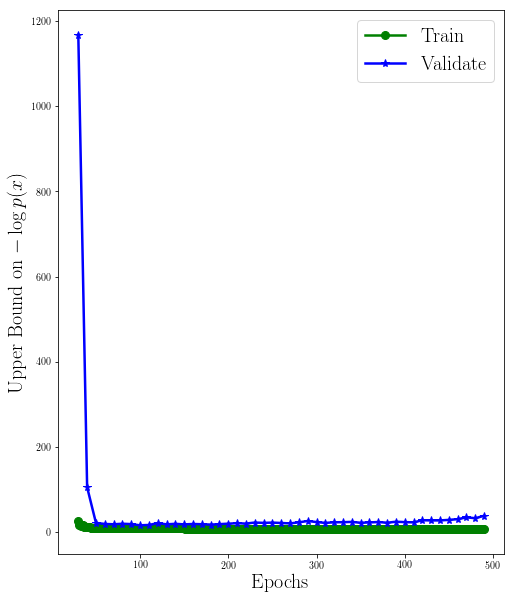

In [11]:
# evaluation
plt.figure(figsize=(8,10))
plt.plot(stats['train_bound'][30:,0],stats['train_bound'][30:,1],'-o',color='g',label='Train')
plt.plot(stats['valid_bound'][3:,0],stats['valid_bound'][3:,1],'-*',color='b',label='Validate')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Upper Bound on $-\log p(x)$')

In [12]:
""" Reload the best DMM based on the validation error """

epochMin, valMin, idxMin = getLowestError(savedata['valid_bound'])
reloadFile= pfile.replace('-config.pkl','')+'-EP'+str(int(epochMin))+'-params.npz'

print 'Loading from : ',reloadFile
params['validate_only']          = True
dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

Loading from :  ./chkpt-ipython//DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP100-params.npz
	<<Reloading Model>>
	<<Loading structure (./chkpt-ipython//DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl) and model (./chkpt-ipython//DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP100-params.npz) / opt (./chkpt-ipython//DMM_lr-0_0008-dh-20-ds-2-nl-relu-bs-200-ep-500-rs-40-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP100-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 14413>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.0>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>


models/__init__.py:201: UserWarning: lr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: anneal found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: update_ctr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")


	<<Completed DMM setup>>
	<<_buildModel took : 22.7321 seconds>>


In [13]:
test_bound = DMM_evaluate.evaluateBound(dmm_best, dataset['test'], batch_size = params['batch_size'])
print("Test bound", test_bound)
print("Validation bound", stats['valid_bound'][-1,1])
print("Train bound", stats['train_bound'][-1,1])

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [ 1 10  1],[ 1 10]>>
	<<(Evaluate) Validation Bound: 15.7582 [Took 0.0031 seconds]>>
('Test bound', 15.7582460356663)
('Validation bound', 38.028417303116484)
('Train bound', 6.7490715800897885)
